In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
import numpy as np
np.set_printoptions(suppress=True)
import openslide as ops

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import pydot
from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from fastprogress import progress_bar
import copy
from collections import namedtuple
import os
import random
import shutil
import time
from PIL import Image,ImageDraw,ImageEnhance,ImageColor 

import pandas as pd
np.set_printoptions(suppress=True)
import cv2
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
import glob

import psutil
from pytorch_grad_cam import GradCAM, \
    ScoreCAM, \
    GradCAMPlusPlus, \
    AblationCAM, \
    XGradCAM, \
    EigenCAM, \
    EigenGradCAM, \
    LayerCAM, \
    FullGrad
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    preprocess_image

from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
Image.MAX_IMAGE_PIXELS = 10000000000
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
def timebase_get_file_list(file_path):
    dir_list = os.listdir(file_path)
    if not dir_list:
        return
    else:
        dir_list = sorted(dir_list,key=lambda x: os.path.getmtime(os.path.join(file_path, x)))
        return dir_list
def namebase_get_file_list(file_path):
    dir_list = os.listdir(file_path)
    if not dir_list:
        return
    else:
        dir_list = sorted(dir_list)
        return dir_list

def detection_3d(model1,test_img):

    timg = Image.fromarray((test_img))
    timg1 = np.array(timg)
    
    testarray = [[] for i in range(4)]
    testarray[0] = timg1 #原图
    testarray[1] = (np.flip(timg1,0))
    testarray[2] = np.rollaxis(timg1,0,2)
    testarray[3] = (np.rot90(timg1,2))
    
    testarray = np.asarray(testarray)
    
    aa = modeleva_3d(model1,testarray)
#     bb= aa[0]
#     bb[0] = np.average(aa[...,0])
#     bb[1] = np.average(aa[...,1])
#     bb[2] = np.average(aa[...,2])
#     bb[3] = np.average(aa[...,3])
#     return aa
    return np.average(aa[:,0]),np.average(aa[:,1])
#     return np.average(aa)

def modeleva_3d(model,test_img):
    test_img = np.asarray(test_img,dtype= np.float32)/255
    return model.predict(test_img)

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),    
    transforms.RandomAffine(degrees = 180, translate= (0.15,0.15), scale=(0.7,1.3), shear=25, resample=False, fillcolor=(240,240,240)) ,  
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation((0,180),fill=(240,240,240)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

/home/q/anaconda3/lib/python3.9/site-packages/torchvision/transforms/transforms.py:1314: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  warnings.warn(
/home/q/anaconda3/lib/python3.9/site-packages/torchvision/transforms/transforms.py:1328: UserWarning: Argument fillcolor is deprecated and will be removed since v0.10.0. Please, use fill instead
  warnings.warn(


In [3]:
data_array = np.load('./train/test/data_array.npy',allow_pickle=True)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [118]:
model_path = 'vgg16_bad2'
# model_id = 50

# model = models.vgg16(init_weights=True)
# # model.classifier[6] = nn. Linear(in_features=4096, out_features=2, bias=True)

# features = list(model.classifier.children())[:-1] # Remove last layer
# features.extend([nn.Linear(4096, 2)]) # Add our layer with 4 outputs
# features.extend([nn.Softmax()])
# model.classifier = nn.Sequential(*features)


# # model = models.resnet101(init_weights=True).to(device)
# # model.fc = nn.Linear(in_features=2048, out_features=2, bias=True).to(device)

# model = nn.DataParallel(model)


model = torch.load('./torchresult/' + model_path + '/best.pth')

if isinstance(model,torch.nn.DataParallel):
    model = model.module
    
# model.classifier[-1] = nn. Linear(in_features=2, out_features=2, bias=True) 
# model.classifier[-1] = nn.Sigmoid()
model.classifier = torch.nn.Sequential(*(list(model.classifier.children())[:-1]))


model.eval()
model.cuda()
# torch.no_grad()
# model.zero_grad()
# model = model.to(device)

# if(os.path.isdir('./result/' + str(model_path) + '/cam_' + str(model_id) + '/') == False):
#     os.mkdir('./result/' + str(model_path) + '/cam_' + str(model_id) + '/')
# if(os.path.isdir('./result/' + str(model_path) + '/camplus_' + str(model_id) + '/') == False):
#     os.mkdir('./result/' + str(model_path) + '/camplus_' + str(model_id) + '/')
# if(os.path.isdir('./result/' + str(model_path) + '/scorecam_' + str(model_id) + '/') == False):
#     os.mkdir('./result/' + str(model_path) + '/scorecam_' + str(model_id) + '/')


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [7]:
summary(model,input_size=(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

In [ ]:
targets

In [37]:
target_layers

[Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))]

In [9]:
batch_size =1

In [220]:
target_layer_names = ["features[-3]"]

target_layers = []
for layer in target_layer_names:
    target_layers.append(eval(f"model.{layer}"))

gradcam = GradCAM1(model=model,
                 target_layers=target_layers,
                 use_cuda=True,reshape_transform=None)

gradcamplusplus = GradCAMPlusPlus(model=model,
                 target_layers=target_layers,
                 use_cuda=True,reshape_transform=None)


# cam.batch_size = 3
target_category = [0]
if target_category is None:
    targets = None
else:
    target0 = [ClassifierOutputTarget(target_category) for _ in range(batch_size)]

target_category = [1]
if target_category is None:
    targets = None
else:
    target1 = [ClassifierOutputTarget(target_category) for _ in range(batch_size)]

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [35]:
target0

In [150]:
target1

In [92]:
target_layers

[Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))]

In [ ]:
input_tensor = torch.tensor(np.expand_dims(np.moveaxis(((test_img/255. -0.5) *2), -1, 0), 0)).type(torch.FloatTensor)
input_tensor = input_tensor.repeat(batch_size, 1, 1, 1).to(device)


camres = cam(input_tensor=input_tensor,
                    targets=targets,
                    aug_smooth=[True],
                    eigen_smooth=[True])

In [ ]:
data_array[7][1][700]

In [17]:
test_img = data_array[7][1][700]

In [284]:
ActivationsAndGradients.save_gradient()

<function __main__.ActivationsAndGradients.save_gradient(self, module, input, output)>

In [7]:
class ActivationsAndGradients1:
    """ Class for extracting activations and
    registering gradients from targetted intermediate layers """

    def __init__(self, model, target_layers, reshape_transform):
        self.model = model
        self.gradients = []
        self.activations = []
        self.reshape_transform = reshape_transform
        self.handles = []
        for target_layer in target_layers:
            print(target_layer)
            self.handles.append(
                target_layer.register_forward_hook(self.save_activation))
            # Because of https://github.com/pytorch/pytorch/issues/61519,
            # we don't use backward hook to record gradients.
            self.handles.append(
                target_layer.register_forward_hook(self.save_gradient))

    def save_activation(self, module, input, output):
        activation = output
        
        if self.reshape_transform is not None:
            activation = self.reshape_transform(activation)
        self.activations.append(activation.cpu().detach())

    def save_gradient(self, module, input, output):
        if not hasattr(output, "requires_grad") or not output.requires_grad:
            # You can only register hooks on tensor requires grad.
            return

        # Gradients are computed in reverse order
        def _store_grad(grad):
#             print("grad shape = ", np.shape(grad))
#             print("grad.max(), grad.min() = ", (grad.cpu().detach()).max(), (grad.cpu().detach()).min())
            if self.reshape_transform is not None:
                grad = self.reshape_transform(grad)
#             print(self.gradients)
#             print([grad.cpu().detach()])
            
            self.gradients = [grad.cpu().detach()] + self.gradients

        output.register_hook(_store_grad)

    def __call__(self, x):
        self.gradients = []
        self.activations = []
        return self.model(x)

    def release(self):
        for handle in self.handles:
            handle.remove()

In [8]:
import cv2
import numpy as np
import torch
from torchvision.transforms import Compose, Normalize, ToTensor


def preprocess_image(img: np.ndarray, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) -> torch.Tensor:
    preprocessing = Compose([
        ToTensor(),
        Normalize(mean=mean, std=std)
    ])
    return preprocessing(img.copy()).unsqueeze(0)


def deprocess_image(img):
    """ see https://github.com/jacobgil/keras-grad-cam/blob/master/grad-cam.py#L65 """
    img = img - np.mean(img)
    img = img / (np.std(img) + 1e-5)
    img = img * 0.1
    img = img + 0.5
    img = np.clip(img, 0, 1)
    return np.uint8(img * 255)


def show_cam_on_image(img: np.ndarray,
                      mask: np.ndarray,
                      use_rgb: bool = False,
                      colormap: int = cv2.COLORMAP_JET) -> np.ndarray:
    """ This function overlays the cam mask on the image as an heatmap.
    By default the heatmap is in BGR format.

    :param img: The base image in RGB or BGR format.
    :param mask: The cam mask.
    :param use_rgb: Whether to use an RGB or BGR heatmap, this should be set to True if 'img' is in RGB format.
    :param colormap: The OpenCV colormap to be used.
    :returns: The default image with the cam overlay.
    """
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), colormap)
    if use_rgb:
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255

    if np.max(img) > 1:
        raise Exception(
            "The input image should np.float32 in the range [0, 1]")

    cam = heatmap + img
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

def scale_cam_image1(cam, target_size=None):
    result = []
    for img in cam:
#         img = img - np.min(img)
#         img = img / (1e-7 + np.max(img))
        
        img = img - np.min(img)
#         print('scale_cam max = ', np.max(img))
        img = img / (1e-7 + np.max(img))
        if target_size is not None:
            img = cv2.resize(img, target_size)
        result.append(img)
    result = np.float32(result)

    return result

def scale_accross_batch_and_channels(tensor, target_size):
    batch_size, channel_size = tensor.shape[:2]
    reshaped_tensor = tensor.reshape(
        batch_size * channel_size, *tensor.shape[2:])
    result = scale_cam_image1(reshaped_tensor, target_size)
    result = result.reshape(
        batch_size,
        channel_size,
        target_size[1],
        target_size[0])
    return result

In [110]:
import numpy as np
import torch
import ttach as tta
from typing import Callable, List, Tuple
from pytorch_grad_cam.utils.svd_on_activations import get_2d_projection
from pytorch_grad_cam.utils.image import scale_cam_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget


class BaseCAM1:
    def __init__(self,
                 model: torch.nn.Module,
                 target_layers: List[torch.nn.Module],
                 use_cuda: bool = False,
                 reshape_transform: Callable = None,
                 compute_input_gradient: bool = False,
                 uses_gradients: bool = True) -> None:
        self.model = model.eval()
        self.target_layers = target_layers
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()
        self.reshape_transform = reshape_transform
        self.compute_input_gradient = compute_input_gradient
        self.uses_gradients = uses_gradients
        self.activations_and_grads1 = ActivationsAndGradients1(
            self.model, target_layers, reshape_transform)

    """ Get a vector of weights for every channel in the target layer.
        Methods that return weights channels,
        will typically need to only implement this function. """

    def get_cam_weights(self,
                        input_tensor: torch.Tensor,
                        target_layers: List[torch.nn.Module],
                        targets: List[torch.nn.Module],
                        activations: torch.Tensor,
                        grads: torch.Tensor) -> np.ndarray:
        raise Exception("Not Implemented")

    def get_cam_image(self,
                      input_tensor: torch.Tensor,
                      target_layer: torch.nn.Module,
                      targets: List[torch.nn.Module],
                      activations: torch.Tensor,
                      grads: torch.Tensor,
                      eigen_smooth: bool = False) -> np.ndarray:

        weights = self.get_cam_weights(input_tensor,
                                       target_layer,
                                       targets,
                                       activations,
                                       grads)
#         print(input_tensor,target_layer,targets,activations,grads)
#         print("weights.shape = ", weights.shape)
#         print("weights.max(), weights.min() = ", weights.max(), weights.min())
#         print("activations.max(), activations.min() = ", activations.max(), activations.min())
        
        weighted_activations = weights[:, :, None, None] * activations
        if eigen_smooth:
            cam = get_2d_projection(weighted_activations)
        else:
            cam = weighted_activations.sum(axis=1)
        return cam

    def forward(self,
                input_tensor: torch.Tensor,
                targets: List[torch.nn.Module],
                eigen_smooth: bool = False) -> np.ndarray:

        if self.cuda:
            input_tensor = input_tensor.cuda()

        if self.compute_input_gradient:
            input_tensor = torch.autograd.Variable(input_tensor,
                                                   requires_grad=True)

        outputs = self.activations_and_grads1(input_tensor)
#         print(outputs)
        if targets is None:
            target_categories = np.argmax(outputs.cpu().data.numpy(), axis=-1)
            targets = [ClassifierOutputTarget(category) for category in target_categories]

        if self.uses_gradients:
            self.model.zero_grad()

#             for target, output in zip(targets, outputs):
#                 print("target = ", target)
#                 print("output = ",  output)
            
            loss = sum([target(output) for target, output in zip(targets, outputs)])
        
            
#             loss2 = loss.cpu().detach()
#             if(max(loss2, 0) == 0):
#                 loss = (loss*0).to(device)

#             print("target(output) = ", target(output))
            print("loss = ", loss)
            loss.backward(retain_graph=True)

        # In most of the saliency attribution papers, the saliency is
        # computed with a single target layer.
        # Commonly it is the last convolutional layer.
        # Here we support passing a list with multiple target layers.
        # It will compute the saliency image for every image,
        # and then aggregate them (with a default mean aggregation).
        # This gives you more flexibility in case you just want to
        # use all conv layers for example, all Batchnorm layers,
        # or something else.
        cam_per_layer = self.compute_cam_per_layer(input_tensor,
                                                   targets,
                                                   eigen_smooth)
#         print('cam_per_layer shape = ', np.shape(cam_per_layer))
#         print("cam_per_layer.max(), cam_per_layer.min() = ", np.max(cam_per_layer), np.min(cam_per_layer))
        
        aggregated_multi_layers = self.aggregate_multi_layers(cam_per_layer)
#         print('aggregated_multi_layers shape = ', np.shape(aggregated_multi_layers))
#         print("aggregated_multi_layers.max(), aggregated_multi_layers.min() = ", np.max(aggregated_multi_layers), np.min(aggregated_multi_layers))
        
        return aggregated_multi_layers

    def get_target_width_height(self,
                                input_tensor: torch.Tensor) -> Tuple[int, int]:
        width, height = input_tensor.size(-1), input_tensor.size(-2)
        return width, height

    def compute_cam_per_layer(
            self,
            input_tensor: torch.Tensor,
            targets: List[torch.nn.Module],
            eigen_smooth: bool) -> np.ndarray:
        activations_list = [a.cpu().data.numpy()
                            for a in self.activations_and_grads1.activations]
#         print("activations_list.shape() = ", np.shape(activations_list))
        grads_list = [g.cpu().data.numpy()
                      for g in self.activations_and_grads1.gradients]
#         print("grads_list shape = ", np.shape(grads_list))
#         print(grads_list)
#         grads_list = [((i*0) + 1) for i in grads_list]
#         print("grads_list.max(), grads_list.min() = ", np.max(grads_list), np.min(grads_list))
        target_size = self.get_target_width_height(input_tensor)

        cam_per_target_layer = []
        # Loop over the saliency image from every layer
        for i in range(len(self.target_layers)):
#             print(self.target_layers[i])
            target_layer = self.target_layers[i]
            layer_activations = None
            layer_grads = None
#             print("i, activations_list, len(activations_list) ", i, np.shape(activations_list),len(activations_list))
            if i < len(activations_list):
                layer_activations = activations_list[i]
            if i < len(grads_list):
                layer_grads = grads_list[i]

            cam = self.get_cam_image(input_tensor,
                                     target_layer,
                                     targets,
                                     (layer_activations),
                                     layer_grads,
                                     eigen_smooth)
#             print("layer_activations.max(),layer_activations.min() ", layer_activations.max(),layer_activations.min())
#             print("layer_grads.max(),layer_grads.min() ", layer_grads.max(),layer_grads.min())
            print('cam.max(),cam.min = ', cam.max(),cam.min())
            cam = np.maximum(cam, 0)
#             cam = cam + np.min(cam)
#             print('cam.max(),cam.min = ', cam.max(),cam.min())
#             print('cam shape = ',  np.shape(cam), ' target_size = ',  np.shape(target_size))
        
            scaled = scale_cam_image1(cam, target_size)
#             print("scaled.max, scaled.min =", scaled.max(),scaled.min())
#             print('scaled shape = ',  np.shape(scaled))
            
#             scaled1 = scale_cam_image1(cam, target_size)
#             print("scaled1.max, scaled1.min =", scaled.max(),scaled.min())
#             print('scaled1 shape = ',  np.shape(scaled))
            
            
#             print("scaled.max, scaled.min =", scaled.max(),scaled.min())
#             print('scaled shape = ',  np.shape(scaled))
            
            cam_per_target_layer.append(scaled[:, None, :])

        return cam_per_target_layer

    def aggregate_multi_layers(self, cam_per_target_layer: np.ndarray) -> np.ndarray:
        cam_per_target_layer = np.concatenate(cam_per_target_layer, axis=1)
        
#         print(cam_per_target_layer.max(),cam_per_target_layer.min())
        
        cam_per_target_layer = np.maximum(cam_per_target_layer, 0)
        result = np.mean(cam_per_target_layer, axis=1)
        return scale_cam_image1(result)

    def forward_augmentation_smoothing(self,
                                       input_tensor: torch.Tensor,
                                       targets: List[torch.nn.Module],
                                       eigen_smooth: bool = False) -> np.ndarray:
        transforms = tta.Compose(
            [
                tta.HorizontalFlip(),
                tta.Multiply(factors=[0.9, 1, 1.1]),
            ]
        )
        cams = []
        for transform in transforms:
            augmented_tensor = transform.augment_image(input_tensor)
            cam = self.forward(augmented_tensor,
                               targets,
                               eigen_smooth)

            # The ttach library expects a tensor of size BxCxHxW
            cam = cam[:, None, :, :]
            cam = torch.from_numpy(cam)
            cam = transform.deaugment_mask(cam)

            # Back to numpy float32, HxW
            cam = cam.numpy()
            cam = cam[:, 0, :, :]
            cams.append(cam)

        cam = np.mean(np.float32(cams), axis=0)
        return cam

    def __call__(self,
                 input_tensor: torch.Tensor,
                 targets: List[torch.nn.Module],
                 aug_smooth: bool = False,
                 eigen_smooth: bool = False) -> np.ndarray:

        # Smooth the CAM result with test time augmentation
        if aug_smooth is True:
            return self.forward_augmentation_smoothing(
                input_tensor, targets, eigen_smooth)

        return self.forward(input_tensor,
                            targets, eigen_smooth)

    def __del__(self):
        self.activations_and_grads1.release()

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, exc_tb):
        self.activations_and_grads1.release()
        if isinstance(exc_value, IndexError):
            # Handle IndexError here...
            print(
                f"An exception occurred in CAM with block: {exc_type}. Message: {exc_value}")
            return True

In [111]:
import numpy as np

class GradCAMPlusPlus1(BaseCAM1):
    def __init__(self, model, target_layers, use_cuda=False,
                 reshape_transform=None):
        super(GradCAMPlusPlus1, self).__init__(model, target_layers, use_cuda,
                                              reshape_transform)

    def get_cam_weights(self,
                        input_tensor,
                        target_layers,
                        target_category,
                        activations,
                        grads):
        grads_power_2 = grads**2
        grads_power_3 = grads_power_2 * grads
        # Equation 19 in https://arxiv.org/abs/1710.11063
        sum_activations = np.sum(activations, axis=(2, 3))
        eps = 0.000001
        aij = grads_power_2 / (2 * grads_power_2 +
                               sum_activations[:, :, None, None] * grads_power_3 + eps)
        # Now bring back the ReLU from eq.7 in the paper,
        # And zero out aijs where the activations are 0
        aij = np.where(grads != 0, aij, 0)

        weights = np.maximum(grads, 0) * aij
        weights = np.sum(weights, axis=(2, 3))
        return weights

In [112]:
import numpy as np

class GradCAM1(BaseCAM1):
    def __init__(self, model, target_layers, use_cuda=False,
                 reshape_transform=None):
        super(
            GradCAM1,
            self).__init__(
            model,
            target_layers,
            use_cuda,
            reshape_transform)

    def get_cam_weights(self,
                        input_tensor,
                        target_layer,
                        target_category,
                        activations,
                        grads):
#         print(grads)
#         print("grads.shape = ", grads.shape)
#         print("grads.max(), grads.min() = ", grads.max(), grads.min())
        
        return np.mean(grads, axis=(2, 3))
#         return grads

In [113]:
target_layer_names = ["features[-1]"]
batch_size =1

target_layers = []
for layer in target_layer_names:
    target_layers.append(eval(f"model.{layer}"))

gradcam = GradCAM1(model=model,
                 target_layers=target_layers,
                 use_cuda=True,reshape_transform=None)

gradcamplusplus = GradCAMPlusPlus1(model=model,
                 target_layers=target_layers,
                 use_cuda=True,reshape_transform=None)


# cam.batch_size = 3
target_category = [0]
if target_category is None:
    targets = None
else:
    target0 = [ClassifierOutputTarget(target_category) for _ in range(batch_size)]

target_category = [1]
if target_category is None:
    targets = None
else:
    target1 = [ClassifierOutputTarget(target_category) for _ in range(batch_size)]

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


In [114]:
gradcam(input_tensor=input_tensor,
                    targets=target0,
                    aug_smooth=[a_smooth],
                    eigen_smooth=[e_smooth]).shape

loss =  tensor([196.2825], device='cuda:0', grad_fn=<AddBackward0>)
cam.max(),cam.min =  0.55661345 -1.642563


(1, 256, 256)

In [166]:
gradcam(input_tensor=input_tensor,
                    targets=target1,
                    aug_smooth=[a_smooth],
                    eigen_smooth=[e_smooth])

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

In [106]:
# test_img = Image.open("./train/test/7_1/svs/11776_21248.png")
# test_img = Image.open("./train/test/7_1/svs/8960_14080.png")
# test_img = Image.open("./train/test/7_1/svs/7936_7680.png")
test_img = Image.open("./train/test/7_1/svs/11776_14336.png")
# test_img = Image.open("./train/test/7_1/svs/21760_19200.png")
input_tensor = test_transform(test_img).unsqueeze(0).to(device)

In [117]:
model(input_tensor).cpu().detach().numpy()

array([[1., 0.]], dtype=float32)

In [108]:
a_smooth = True
e_smooth = True

loss =  tensor([196.2825], device='cuda:0', grad_fn=<AddBackward0>)
cam.max(),cam.min =  0.55661345 -1.642563
loss =  tensor([-197.4014], device='cuda:0', grad_fn=<AddBackward0>)
cam.max(),cam.min =  0.565603 -1.6584871
loss =  tensor([196.2825], device='cuda:0', grad_fn=<AddBackward0>)
cam.max(),cam.min =  8.842665 -5.345519
loss =  tensor([-197.4014], device='cuda:0', grad_fn=<AddBackward0>)
cam.max(),cam.min =  8.206698 -11.228558


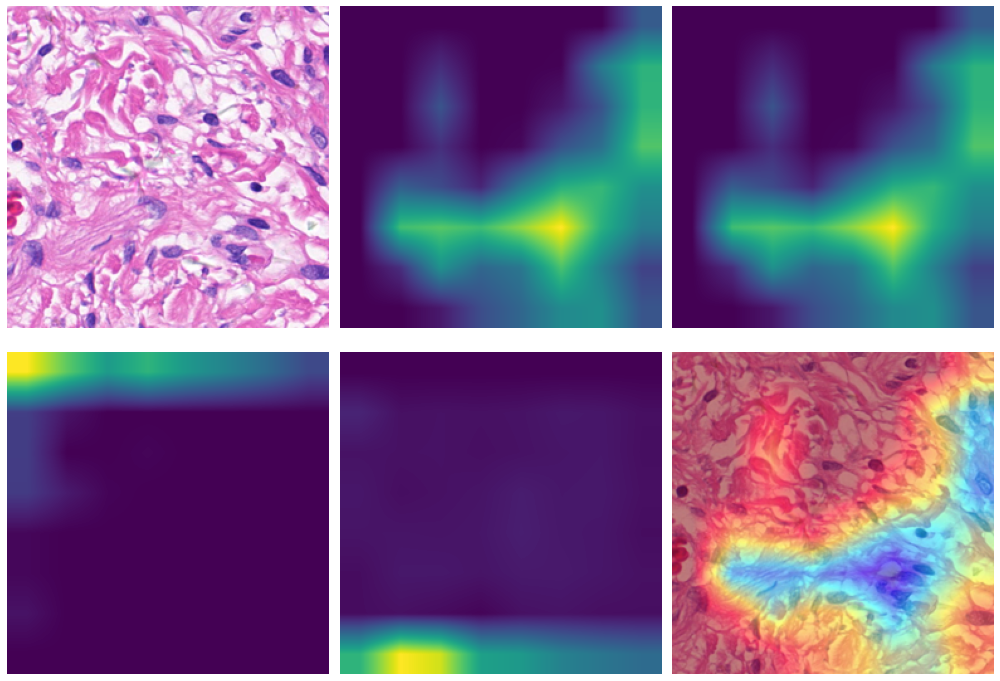

In [115]:
# input_tensor = ((test_img/255. -0.5) *2)

# # input_tensor = test_img
# input_tensor = np.expand_dims(np.moveaxis(input_tensor, -1, 0), 0)
# input_tensor = input_tensor.repeat(batch_size, 0)
# input_tensor = torch.tensor(input_tensor).type(torch.FloatTensor)
input_tensor = test_transform(test_img).unsqueeze(0).to(device)
a_smooth = True
e_smooth = True

gradcam0 = gradcam(input_tensor=input_tensor,
                    targets=target0,
                    aug_smooth=[a_smooth],
                    eigen_smooth=[e_smooth])

gradcam1 = gradcam(input_tensor=input_tensor,
                    targets=target1,
                    aug_smooth=[a_smooth],
                    eigen_smooth=[e_smooth])

gradcampp0 = gradcamplusplus(input_tensor=input_tensor,
                    targets=target0,
                    aug_smooth=[a_smooth],
                    eigen_smooth=[e_smooth])

gradcampp1 = gradcamplusplus(input_tensor=input_tensor,
                    targets=target1,
                    aug_smooth=[a_smooth],
                    eigen_smooth=[e_smooth])

# test_img2 = (test_img/255. -0.5) *2
# input_tensor = np.stack((test_img, test_img2))
# input_tensor = torch.tensor(np.moveaxis(input_tensor, -1, 1)).type(torch.FloatTensor)

# input_tensor = input_tensor.repeat(batch_size, 1, 1, 1).to(device)




f, ax = plt.subplots(nrows=2, ncols=3, figsize=(14, 10))
ax[0,0].imshow(test_img)
ax[0,0].axis('off')
ax[0,1].imshow(gradcam0[0])
ax[0,1].axis('off')
ax[0,2].imshow(gradcam1[0])
ax[0,2].axis('off')
ax[1,0].imshow(gradcampp0[0])
ax[1,0].axis('off')
ax[1,1].imshow(gradcampp1[0])
ax[1,1].axis('off')
ax[1,2].imshow(show_cam_on_image(np.float32(test_img) / 255, gradcam1[0]))
ax[1,2].axis('off')

plt.tight_layout()
plt.show()

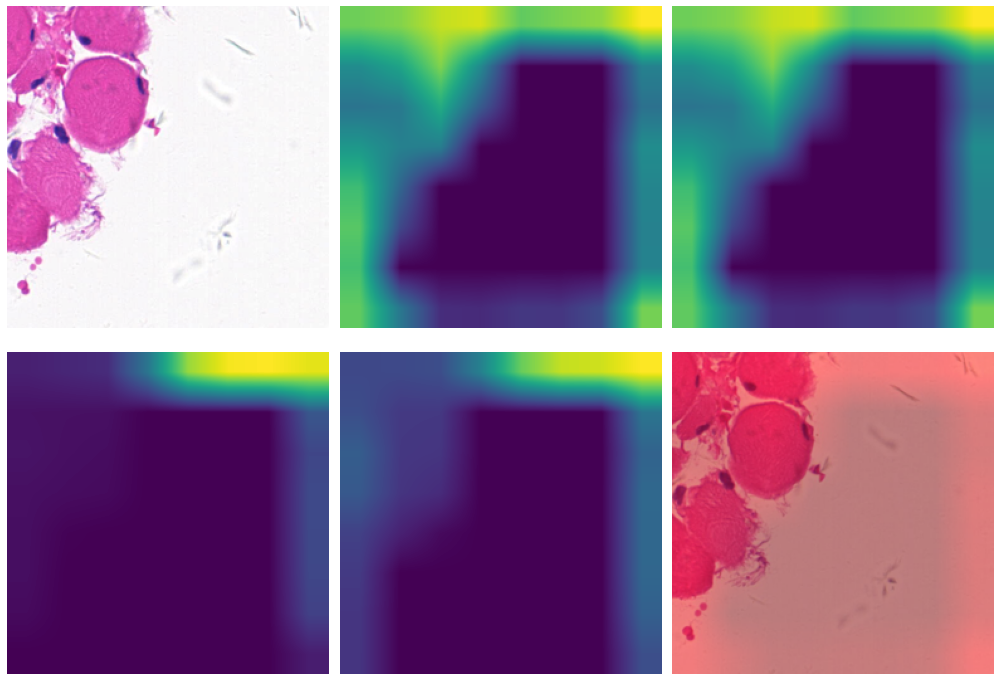

In [143]:
# input_tensor = ((test_img/255. -0.5) *2)

# # input_tensor = test_img
# input_tensor = np.expand_dims(np.moveaxis(input_tensor, -1, 0), 0)
# input_tensor = input_tensor.repeat(batch_size, 0)
# input_tensor = torch.tensor(input_tensor).type(torch.FloatTensor)
input_tensor = test_transform(test_img).unsqueeze(0).to(device)
a_smooth = True
e_smooth = True

gradcam0 = gradcam(input_tensor=input_tensor,
                    targets=target0,
                    aug_smooth=[a_smooth],
                    eigen_smooth=[e_smooth])

gradcam1 = gradcam(input_tensor=input_tensor,
                    targets=target1,
                    aug_smooth=[a_smooth],
                    eigen_smooth=[e_smooth])

gradcampp0 = gradcamplusplus(input_tensor=input_tensor,
                    targets=target0,
                    aug_smooth=[a_smooth],
                    eigen_smooth=[e_smooth])

gradcampp1 = gradcamplusplus(input_tensor=input_tensor,
                    targets=target1,
                    aug_smooth=[a_smooth],
                    eigen_smooth=[e_smooth])

# test_img2 = (test_img/255. -0.5) *2
# input_tensor = np.stack((test_img, test_img2))
# input_tensor = torch.tensor(np.moveaxis(input_tensor, -1, 1)).type(torch.FloatTensor)

# input_tensor = input_tensor.repeat(batch_size, 1, 1, 1).to(device)




f, ax = plt.subplots(nrows=2, ncols=3, figsize=(14, 10))
ax[0,0].imshow(test_img)
ax[0,0].axis('off')
ax[0,1].imshow(gradcam0[0])
ax[0,1].axis('off')
ax[0,2].imshow(gradcam1[0])
ax[0,2].axis('off')
ax[1,0].imshow(gradcampp0[0])
ax[1,0].axis('off')
ax[1,1].imshow(gradcampp1[0])
ax[1,1].axis('off')
ax[1,2].imshow(show_cam_on_image(np.float32(test_img) / 255, gradcam0[0]))
ax[1,2].axis('off')

plt.tight_layout()
plt.show()

In [188]:
gradcam0[0].max()

0.9999999

In [18]:
np.average(gradcam0, axis=0)

(256, 256)

In [ ]:
噪音背景 = copy.deepcopy(camres[0])

In [97]:
def gradcam_3d(model1,test_img):

    PILImage = Image.fromarray(test_img)

    input_tensor = test_transform(PILImage).unsqueeze(0).to(device)
#     input_tensor = torch.tensor(np.expand_dims(np.moveaxis(test_img, -1, 0), 0)).type(torch.FloatTensor).to(device)
    
    gradcam0 = gradcam(input_tensor=input_tensor,
                    targets=target0,
                    aug_smooth=[True],
                    eigen_smooth=[True])

    gradcam1 = gradcam(input_tensor=input_tensor,
                        targets=target1,
                        aug_smooth=[True],
                        eigen_smooth=[True])

    gradcampp0 = gradcamplusplus(input_tensor=input_tensor,
                        targets=target0,
                        aug_smooth=[True],
                        eigen_smooth=[True])

    gradcampp1 = gradcamplusplus(input_tensor=input_tensor,
                        targets=target1,
                        aug_smooth=[True],
                        eigen_smooth=[True])
    
    
    return gradcam0[0], gradcam1[0], gradcampp0[0], gradcampp1[0]

In [20]:
def gradcam_3d(model1,test_img):

    timg1 = np.asarray(test_img)
    
    images = np.asarray([np.array(timg1), np.array(np.flip(timg1,0)), np.array(np.rollaxis(timg1,0,2)), np.array((np.rot90(timg1,2)))])

    input_tensor = torch.tensor(np.expand_dims(np.moveaxis(img1, -1, 0), 0)).type(torch.FloatTensor).to(device)

    gradcam = Gradcam(model1,
                      model_modifier=replace2linear,
                      clone=True)

    # Generate heatmap with GradCAM
    cam = gradcam(score,
                  X,
                  penultimate_layer=layer)
    
    camres = cam(input_tensor=input_tensor,
                        targets=targets,
                        aug_smooth=[False],
                        eigen_smooth=[True,False])
    
    aa = copy.deepcopy((images)*0.)       
    aa[0] = np.uint8(cm.jet(camres[0])[..., :3] * 255)
    aa[1] = np.flip((np.uint8(cm.jet(camres[1])[..., :3] * 255)),0)   
    aa[2] = np.rollaxis(np.uint8(cm.jet(camres[2])[..., :3] * 255),0,2)
    aa[3] = np.rot90((np.uint8(cm.jet(camres[3])[..., :3] * 255)),2)
    
    temp_cam_all = aa[0] + aa[1] + aa[2]  + aa[3]
    return temp_cam_all

def gradcamplusplus_3d(model1,test_img):

    timg1 = np.asarray(test_img)
    
    images = np.asarray([np.array(timg1), np.array(np.flip(timg1,0)), np.array(np.rollaxis(timg1,0,2)), np.array((np.rot90(timg1,2)))])

    X = images/255

    gradcam = GradcamPlusPlus(model1,
                      model_modifier=replace2linear,
                      clone=True)

    # Generate heatmap with GradCAM
    cam = gradcam(score,
                  X,
                  penultimate_layer=layer)
    
    aa = copy.deepcopy((images)*0.)       
    aa[0] = np.uint8(cm.jet(cam[0])[..., :3] * 255)
    aa[1] = np.flip((np.uint8(cm.jet(cam[1])[..., :3] * 255)),0)   
    aa[2] = np.rollaxis(np.uint8(cm.jet(cam[2])[..., :3] * 255),0,2)
    aa[3] = np.rot90((np.uint8(cm.jet(cam[3])[..., :3] * 255)),2)
    
    temp_cam_all = aa[0] + aa[1] + aa[2]  + aa[3]
    return temp_cam_all

def scorecam_3d(model1,test_img):

    timg1 = np.asarray(test_img)
    
    images = np.asarray([np.array(timg1), np.array(np.flip(timg1,0)), np.array(np.rollaxis(timg1,0,2)), np.array((np.rot90(timg1,2)))])

    X = images/255

    cam = scorecam(score,
                   X,
                   penultimate_layer=layer,
                   max_N=10)
    
    aa = copy.deepcopy((images)*0.)       
    aa[0] = np.uint8(cm.jet(cam[0])[..., :3] * 255)
    aa[1] = np.flip((np.uint8(cm.jet(cam[1])[..., :3] * 255)),0)   
    aa[2] = np.rollaxis(np.uint8(cm.jet(cam[2])[..., :3] * 255),0,2)
    aa[3] = np.rot90((np.uint8(cm.jet(cam[3])[..., :3] * 255)),2)
    
    temp_cam_all = aa[0] + aa[1] + aa[2]  + aa[3]
    return temp_cam_all       
    

In [144]:
def gen_res(model1,test_img):

#     timg1 = ((cv2.resize(np.asarray(test_img),(224,224), interpolation = cv2.INTER_AREA   )/255.)-0.5)*2

#     test_img = ((test_img/255. -0.5) *2)
    
    input_tensor = torch.tensor(np.expand_dims(np.moveaxis(test_img, -1, 0), 0)).type(torch.FloatTensor).to(device)

    return model1(input_tensor)

In [100]:
patch_size = 256
overlap = 128
print(model_path)
for types,mask_id in progress_bar([(7,1)]):
# for types,mask_id in progress_bar([(1,1),(1,3),(1,4),(4,1),(4,2),(4,3),(4,4),(4,5),(7,1),(7,4)]):
# for types in [1]:
#     for mask_id in range(1,2):
        
    if(os.path.exists(r'./train/test/' + str(types) + '/svs/' + str(types) + '_' + str(mask_id) + r'.svs')==True):

#             tif = ops.open_slide(r'./train/test/' + str(types) + '/svs/' + str(types) + '_' + str(mask_id) + r'.svs')

        god_img_mask = copy.deepcopy(np.asarray(Image.open(r'./train/test/' + str(types) + '/svs/' + str(types) + '_' + str(mask_id) + r'_good.png')))
        god_img_mask = cv2.resize(god_img_mask, (god_img_mask.shape[1]//2 , god_img_mask.shape[0]//2),interpolation = cv2.INTER_AREA    )

#             bad_img_mask = copy.deepcopy(np.asarray(Image.open(r'./train/test/' + str(types) + '/svs/' + str(types) + '_' + str(mask_id) + r'_bad.png')))
#             bad_img_mask = cv2.resize(bad_img_mask, (god_img_mask.shape[1],god_img_mask.shape[0]),interpolation = cv2.INTER_AREA    )

        gc0 = np.zeros((god_img_mask.shape[0],god_img_mask.shape[1]), dtype = np.float64)
        gc1 = copy.deepcopy(gc0)
        gcpp0 = copy.deepcopy(gc0)
        gcpp1 = copy.deepcopy(gc0)
        sub_mask    = copy.deepcopy(np.asarray(god_img_mask*0, dtype = np.uint8))


#             total_size = bad_img_mask.shape[1],bad_img_mask.shape[0]

        for temp_patch in progress_bar(data_array[types][mask_id]):
            test_img = temp_patch[2]
            x = temp_patch[0]//2
            y = temp_patch[1]//2

            cam_result = gradcam_3d(model, test_img)

            gc0[y:y+patch_size,x:x+patch_size]   += cam_result[0]
            gc1[y:y+patch_size,x:x+patch_size]   += cam_result[1]
            gcpp0[y:y+patch_size,x:x+patch_size] += cam_result[2]
            gcpp1[y:y+patch_size,x:x+patch_size] += cam_result[3]
            sub_mask[y:y+patch_size,x:x+patch_size] +=1

        sub_mask[sub_mask==0] = 1
        gc0 = gc0/sub_mask
        gc1 = gc1/sub_mask
        gcpp0 = gcpp0/sub_mask
        gcpp1 = gcpp1/sub_mask
        
#         np.save('./result/' + str(model_path) + '/camplus_' + str(model_id) + '/' + str(types) + '_' + str(mask_id),  gradcam_mask2)


vgg16_bad2


In [207]:
patch_size = 256
overlap = 128
print(model_path)
for types,mask_id in progress_bar([(7,1)]):
# for types,mask_id in progress_bar([(1,1),(1,3),(1,4),(4,1),(4,2),(4,3),(4,4),(4,5),(7,1),(7,4)]):
# for types in [1]:
#     for mask_id in range(1,2):
        
    if(os.path.exists(r'./train/test/' + str(types) + '/svs/' + str(types) + '_' + str(mask_id) + r'.svs')==True):

#             tif = ops.open_slide(r'./train/test/' + str(types) + '/svs/' + str(types) + '_' + str(mask_id) + r'.svs')

        god_img_mask = copy.deepcopy(np.asarray(Image.open(r'./train/test/' + str(types) + '/svs/' + str(types) + '_' + str(mask_id) + r'_good.png')))
        god_img_mask = cv2.resize(god_img_mask, (god_img_mask.shape[1]//2 , god_img_mask.shape[0]//2),interpolation = cv2.INTER_AREA    )

#             bad_img_mask = copy.deepcopy(np.asarray(Image.open(r'./train/test/' + str(types) + '/svs/' + str(types) + '_' + str(mask_id) + r'_bad.png')))
#             bad_img_mask = cv2.resize(bad_img_mask, (god_img_mask.shape[1],god_img_mask.shape[0]),interpolation = cv2.INTER_AREA    )

        gradcam_mask = np.zeros((god_img_mask.shape[0],god_img_mask.shape[1]), dtype = np.float64)
        sub_mask    = copy.deepcopy(np.asarray(god_img_mask*0, dtype = np.uint8))


#             total_size = bad_img_mask.shape[1],bad_img_mask.shape[0]

        for temp_patch in progress_bar(data_array[types][mask_id]):
            test_img = temp_patch[2]
            x = temp_patch[0]//2
            y = temp_patch[1]//2

#             cam_result = gradcam_3d(model, test_img)
            cam_result = np.sum(gen_res(model, test_img).cpu().detach().numpy()[...,1])

            gradcam_mask[y:y+patch_size,x:x+patch_size] += cam_result
            sub_mask[y:y+patch_size,x:x+patch_size] +=1

        gradcam_mask2 = copy.deepcopy(gradcam_mask)
        sub_mask[sub_mask==0] = 1
        gradcam_mask2 = gradcam_mask2/sub_mask

#         np.save('./result/' + str(model_path) + '/camplus_' + str(model_id) + '/' + str(types) + '_' + str(mask_id),  gradcam_mask2)


vgg16_bad2


In [ ]:
test_transform(PILImage).unsqueeze(0).shape

In [ ]:
PILImage = Image.fromarray(test_img)
    
model(test_transform(PILImage).unsqueeze(0).to(device))

In [40]:
def gen_res(model1,test_img):
    PILImage = Image.fromarray(test_img)

    return model1(test_transform(PILImage).unsqueeze(0).to(device))

In [ ]:
def gradcam_3d(model1,test_img):
#     PILImage = Image.fromarray(cv2.resize(test_img, (224,224), interpolation = cv2.INTER_AREA))
    PILImage = Image.fromarray(test_img)
    
    stack_ab = torch.stack([test_transform(PILImage), test_transform(PILImage),test_transform(PILImage),test_transform(PILImage)], dim = 0).to(device)

    return model(stack_ab)

In [ ]:
float(gradcam_3d(model, test_img)[0][1].cpu().detach().numpy())

In [ ]:
np.sum(gradcam_3d(model, test_img).cpu().detach().numpy()[...,1])

In [ ]:
gradcam_3d(model, test_img).cpu().detach().numpy()

In [ ]:
gradcam_3d(model, test_img)

In [ ]:
plt.figure(figsize=(30,20))
plt.imshow(np.transpose(test_transform(Image.fromarray(test_img)).numpy(), (1,2,0))/2+0.5  , interpolation='nearest')
plt.show()

In [ ]:
input_tensor = test_transform(Image.fromarray(test_img)).to(device)

In [ ]:
input_tensor.shape

In [ ]:
gradcam_3d(model, test_img)

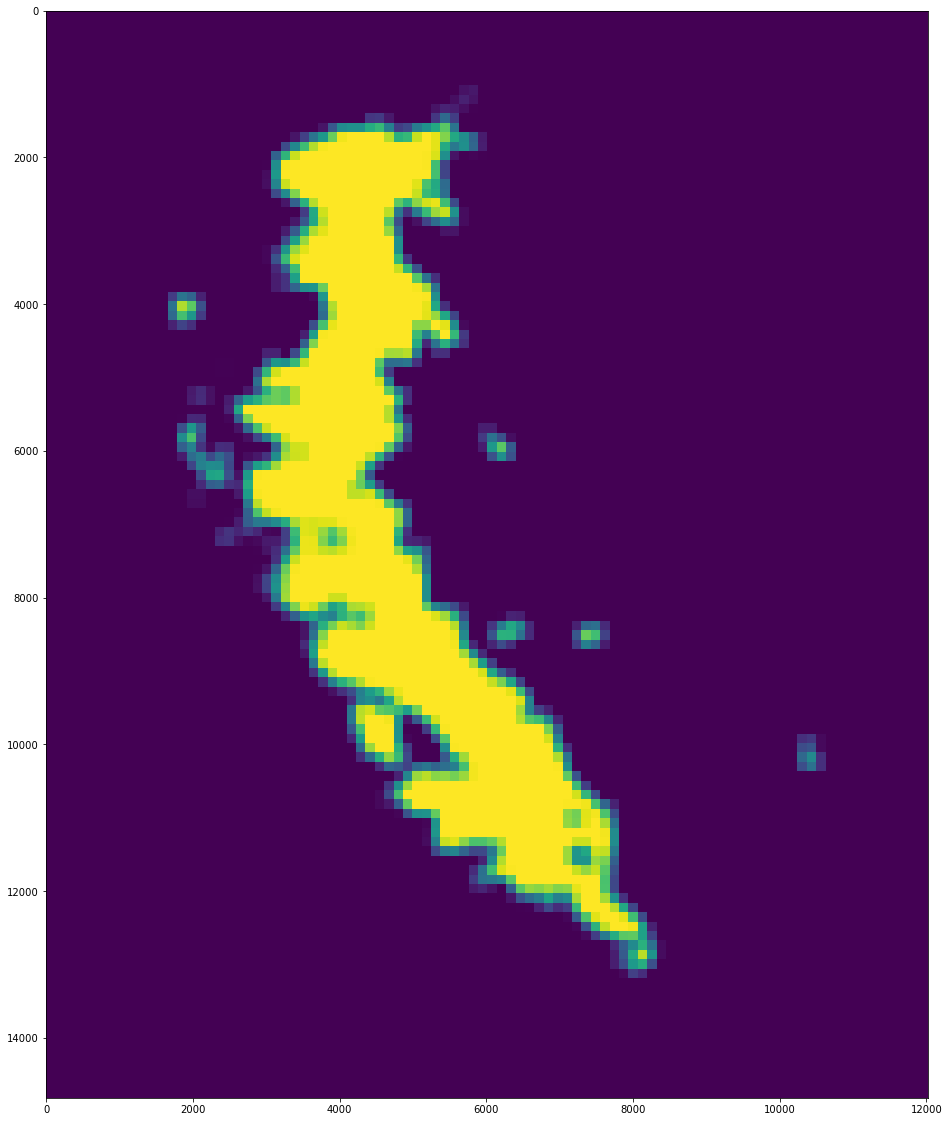

In [216]:
a = copy.deepcopy(gradcam_mask2)
plt.figure(figsize=(30,20))
plt.imshow(a, interpolation='nearest')
plt.show()

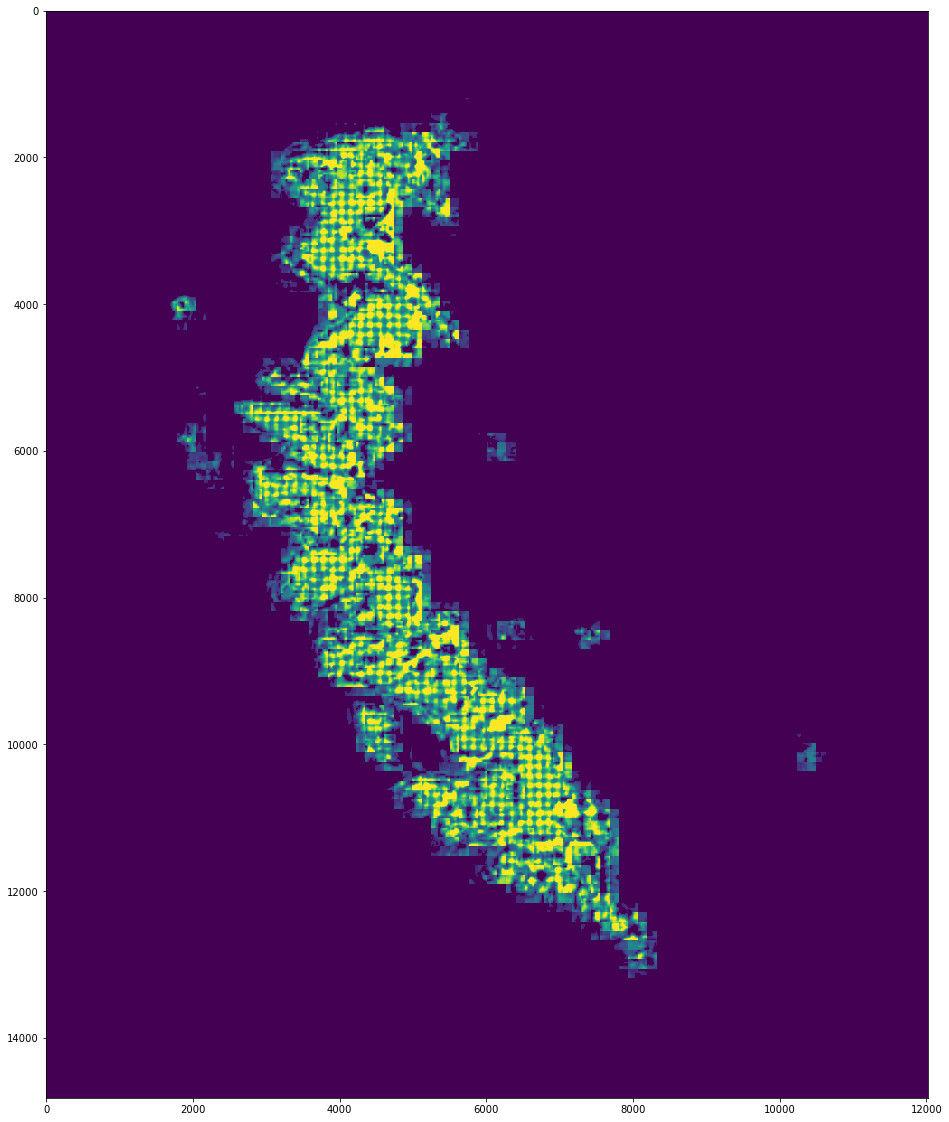

In [217]:
a = copy.deepcopy(gcpp1*gradcam_mask2)
a[a<0.05] = 0
a[a>0.5] = 0.5
plt.figure(figsize=(30,20))
plt.imshow(a, interpolation='nearest')
plt.show()

In [ ]:
gradcam_mask2 = copy.deepcopy(gradcam_mask)

sub_mask[sub_mask==0] = 1

gradcam_mask2 = gradcam_mask2/(np.stack([sub_mask,sub_mask,sub_mask],2))

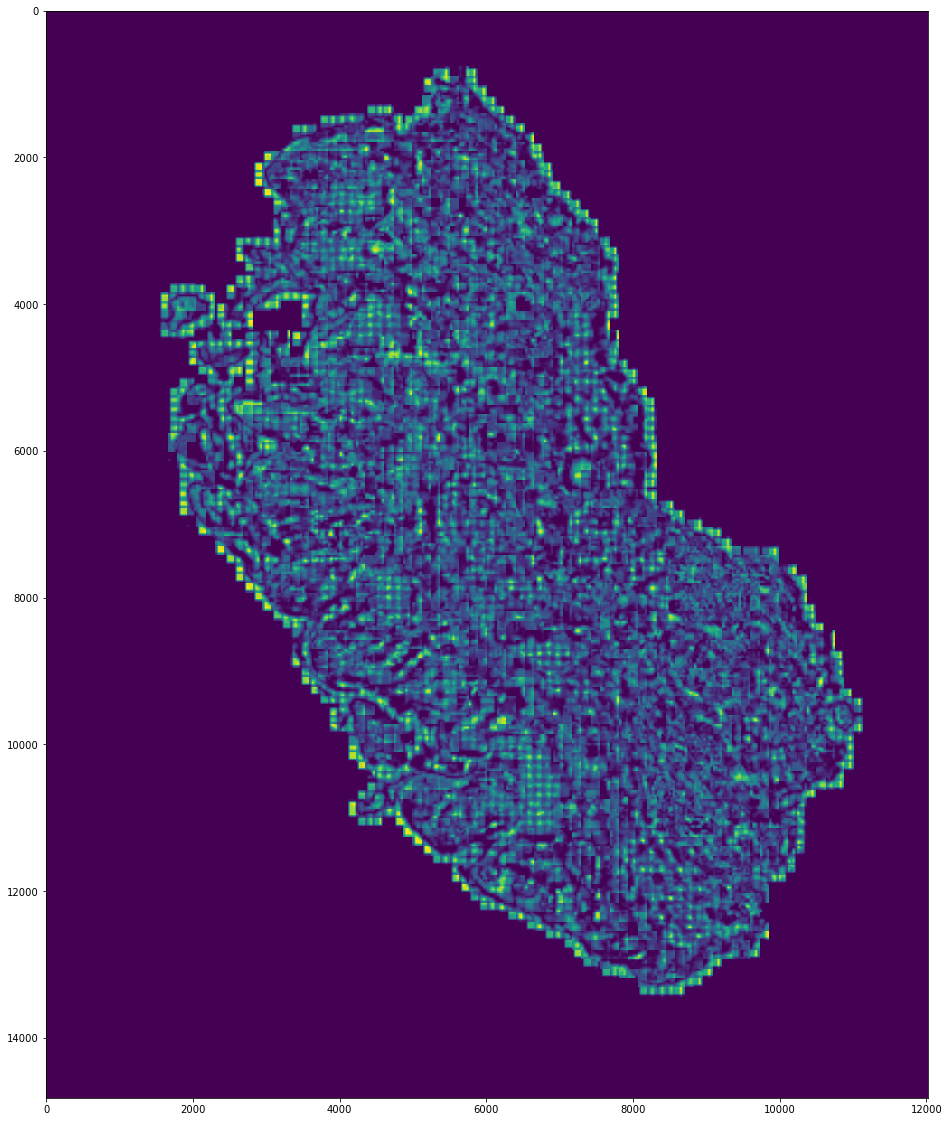

In [203]:
a = copy.deepcopy(gc0)
# a[a<0] = 0
a[a>1] = 1
plt.figure(figsize=(30,20))
plt.imshow(a, interpolation='nearest')
plt.show()

In [119]:
plt.figure(figsize=(30,20))
plt.imshow(gc0, interpolation='nearest')
plt.show()

NameError: name 'gc0' is not defined

<Figure size 2160x1440 with 0 Axes>

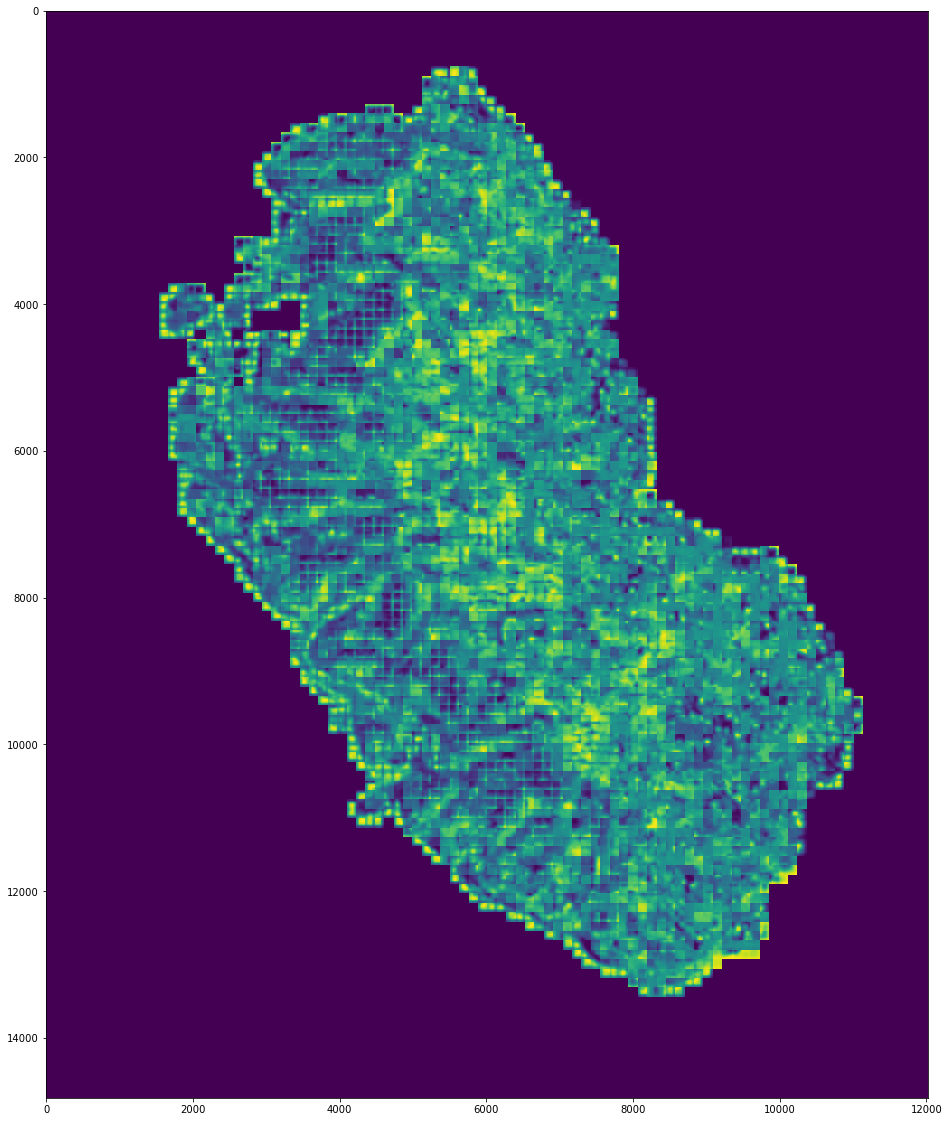

In [102]:
plt.figure(figsize=(30,20))
plt.imshow(gc1, interpolation='nearest')
plt.show()

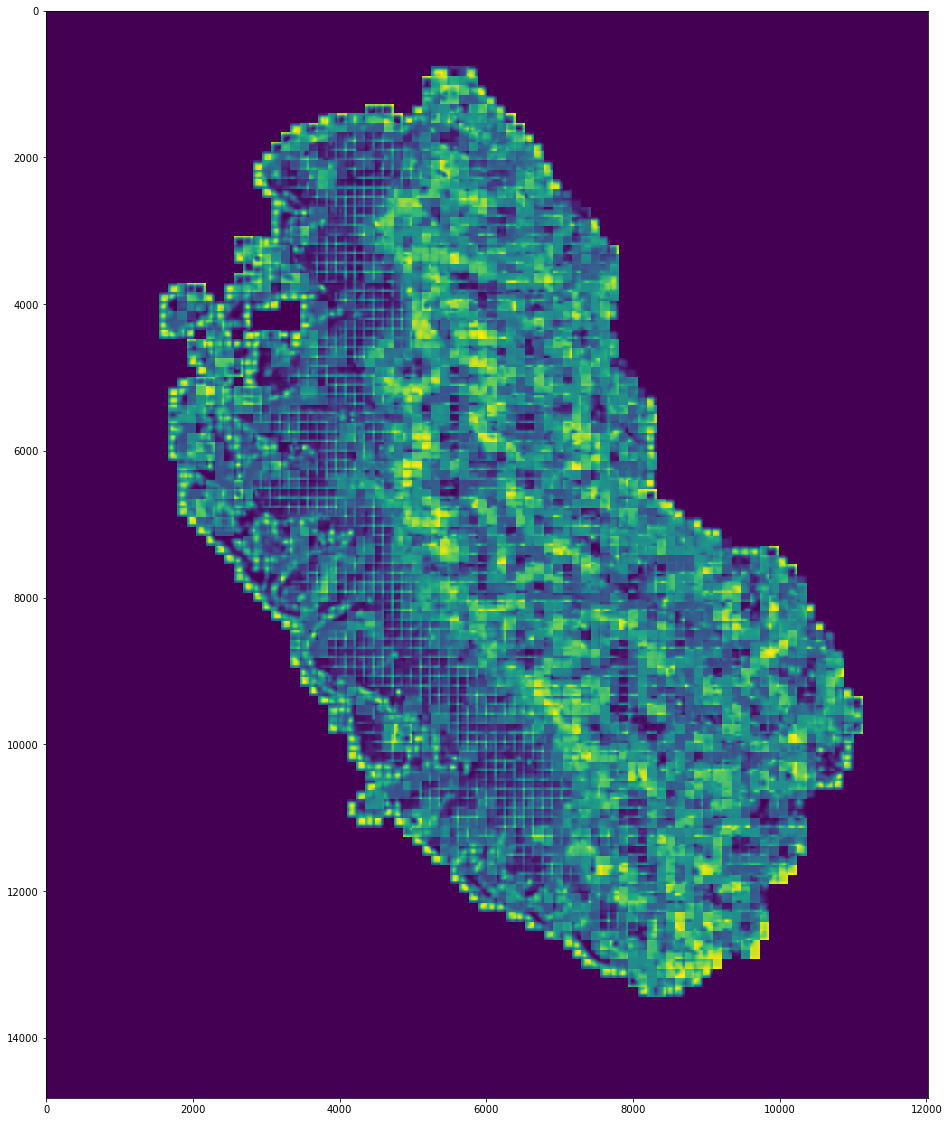

In [103]:
plt.figure(figsize=(30,20))
plt.imshow(gcpp0, interpolation='nearest')
plt.show()

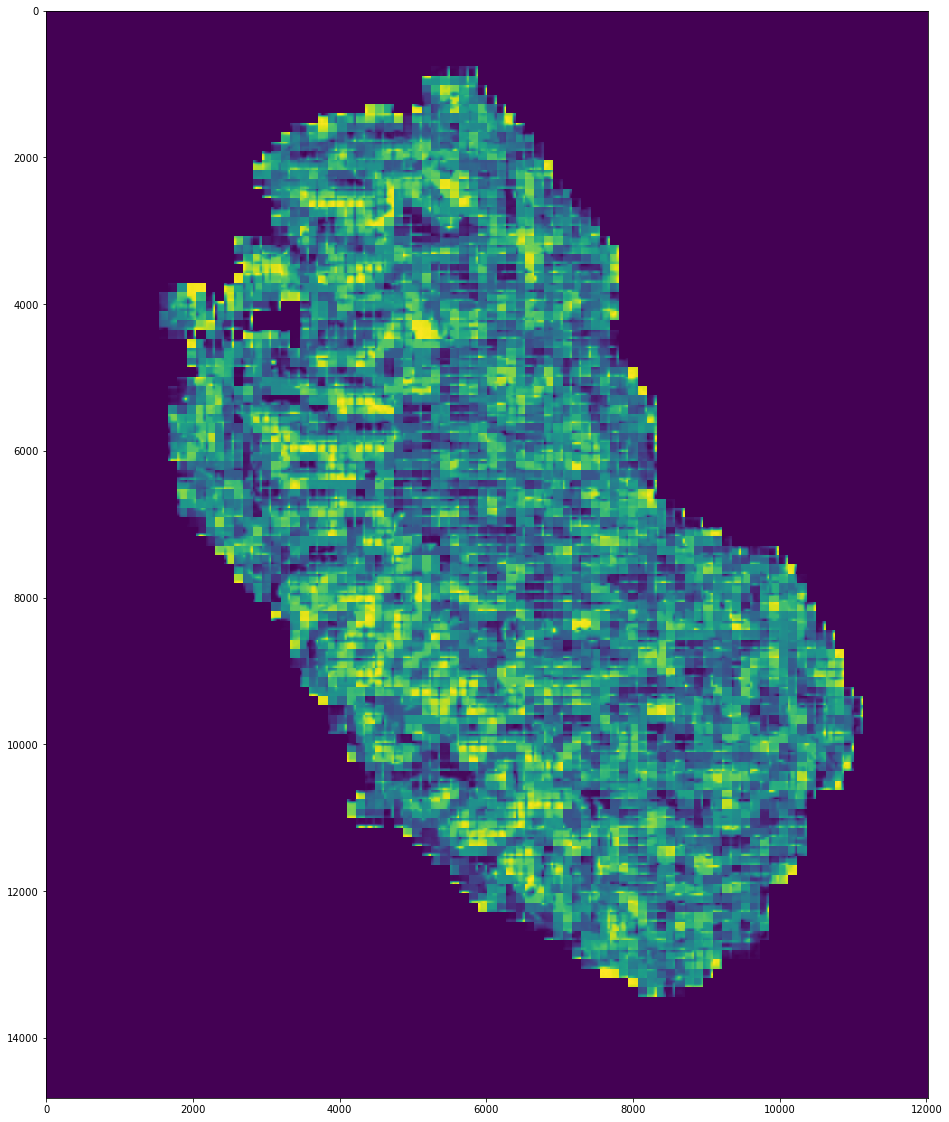

In [104]:
plt.figure(figsize=(30,20))
plt.imshow(gcpp1, interpolation='nearest')
plt.show()

In [163]:
plt.figure(figsize=(30,20))
plt.imshow(gradcam_mask2, interpolation='nearest')
plt.show()

NameError: name 'gradcam_mask2' is not defined

<Figure size 2160x1440 with 0 Axes>

In [ ]:
np.save('./result/vgg16_bad1_50_' + str(types) + '_' + str(mask_id),  gradcam_mask2)

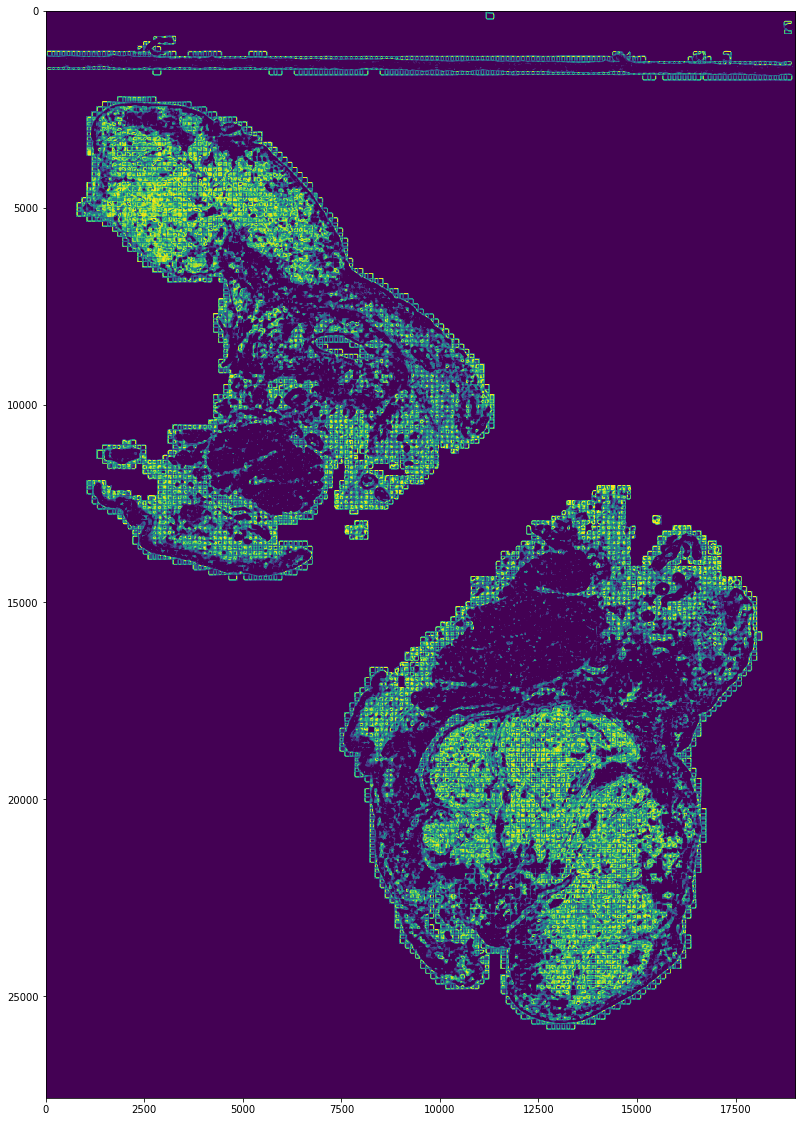

In [72]:
plt.figure(figsize=(30,20))
plt.imshow(gradcam_mask2[...,1], interpolation='nearest')
plt.show()

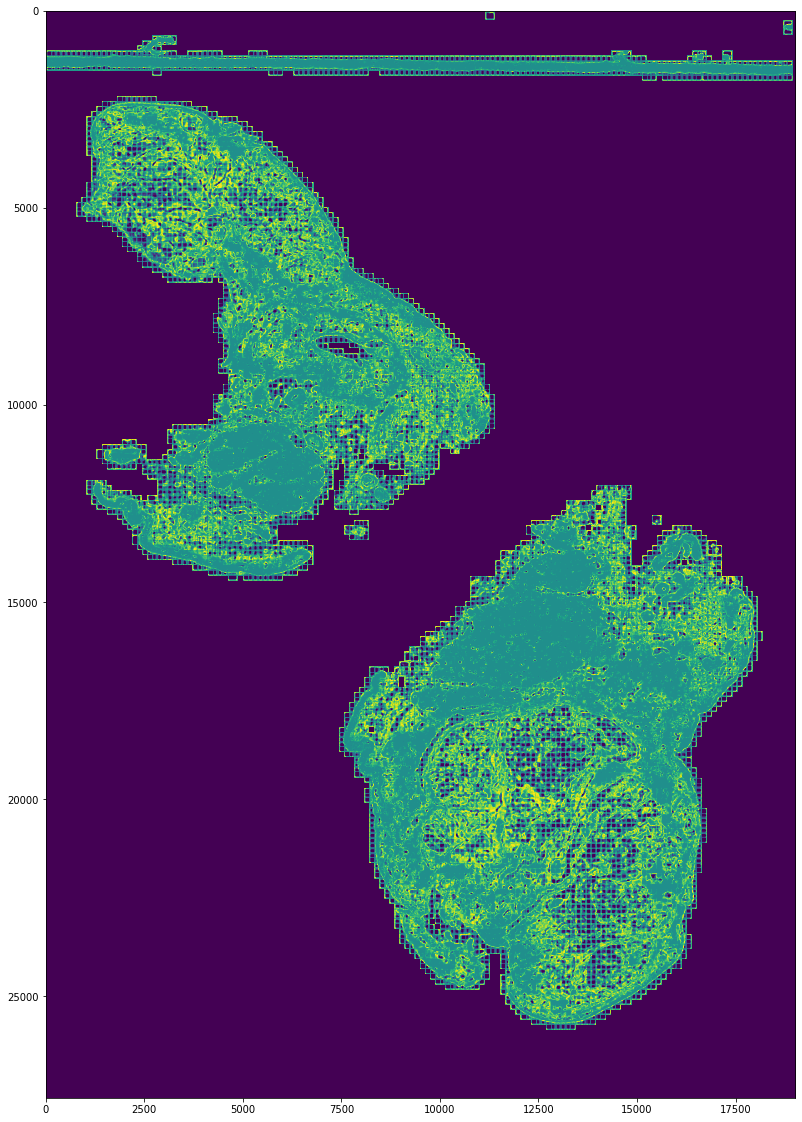

In [73]:
plt.figure(figsize=(30,20))
plt.imshow(gradcam_mask2[...,2], interpolation='nearest')
plt.show()

In [48]:
god_img_mask2 = copy.deepcopy(np.asarray(Image.open(r'./train/test/' + str(types) + '/svs/' + str(types) + '_' + str(mask_id) + r'_good.png')))

In [50]:
god_img_mask.shape

(19018, 27579)

In [55]:
god_img_mask2.shape

(55158, 38037)

In [45]:
gradcam_mask.shape


(19018, 27579, 3)

In [46]:
[y,y+patch_size,x,x+patch_size]

[18816, 19072, 7808, 8064]

In [34]:
gradcam_mask[y:y+patch_size,x:x+patch_size].shape

(0, 256, 3)

In [24]:
import keras

In [79]:
from tf_keras_vis.gradcam import Gradcam


In [40]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input
from tf_keras_vis.scorecam import Scorecam
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus

from keras.backend import set_session
from keras.backend import clear_session
from keras.backend import get_session
import gc

# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass
    
    gc.collect()
#     print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tf.compat.v1.Session(config=config))

In [108]:
tf.keras.backend.clear_session()

In [ ]:
# del model
model = keras.models.load_model('./result/vgg16_bad1/50-0.13.h5')

In [103]:
from keras import backend as K
K.clear_session()

In [41]:
reset_keras()

In [25]:
i

10

In [ ]:
for i in range(0,50):
    cam_result = copy.deepcopy(gradcam_3d(model, img3))

In [16]:
def evaluate():
    for i in range(0,5):
        cam_result = copy.deepcopy(gradcam_3d(model, img3))
    print(i)

In [ ]:
cam_result

In [22]:
import multiprocessing

process_eval = multiprocessing.Process(target=evaluate, args=())
process_eval.start()
process_eval.join()

In [55]:
gradcam_mask[y:y+patch_size,x:x+patch_size].shape

(512, 512, 3)

In [ ]:
images = np.asarray([np.array(img1), np.array(img2), np.array(img3)])

# Preparing input data for VGG16
X = preprocess_input(images)

cam = scorecam(score, X, penultimate_layer=-1)

heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)

In [27]:
X.shape

(3, 256, 256, 3)

In [47]:
temp_cam = gradcam_3d(model, img3)

In [51]:
temp_cam.shape

(256, 256, 3)

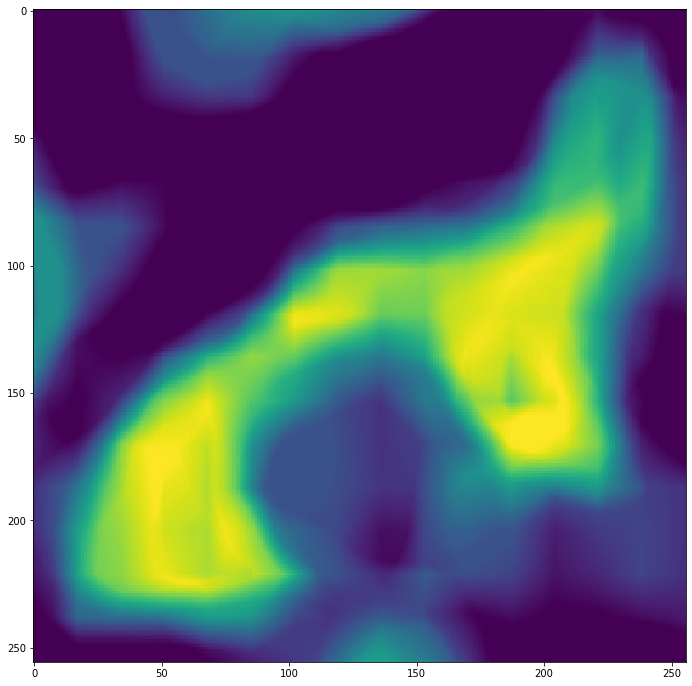

In [49]:
plt.figure(figsize=(12,12))
plt.imshow(temp_cam[...,0], interpolation='nearest')
plt.show()
# imshow(temp_cam_all[...,2], cmap='jet', alpha=1)

# plt.show()

TypeError: 'AxesSubplot' object does not support indexing

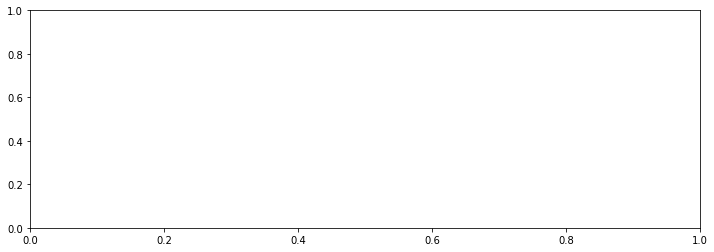

In [37]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
#     ax[i].imshow(images[i])
    ax[i].imshow(temp_cam_all[...,2], cmap='jet', alpha=1)
    ax[i].axis('off')
plt.tight_layout()
plt.show()


In [30]:
temp_cam[1][...,2]

array([[127., 127., 127., ..., 232., 227., 218.],
       [127., 127., 127., ..., 236., 227., 218.],
       [127., 127., 127., ..., 236., 227., 218.],
       ...,
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.]])

In [31]:
timg1 = np.asarray(img1)

#     images = np.asarray([np.array(img1), np.array(np.flip(timg1,0)), np.array(np.rollaxis(timg1,0,2)), np.array(np.rot90(timg1,2))])

#     images = np.asarray([np.array(img1), np.array(img2), np.array(img3)])

# Preparing input data for VGG16
#     X = preprocess_input(images)

testarray = np.zeros((4, timg1.shape[0], timg1.shape[1], timg1.shape[2]) ,dtype=np.uint8)
testarray[0] = timg1 #原图
testarray[1] = (np.flip(timg1,0))
testarray[2] = np.rollaxis(timg1,0,2)
testarray[3] = (np.rot90(timg1,2))

X = np.asarray(testarray)
#     print(testarray.shape)

#     X = preprocess_input(images)
#     print(X.shape)



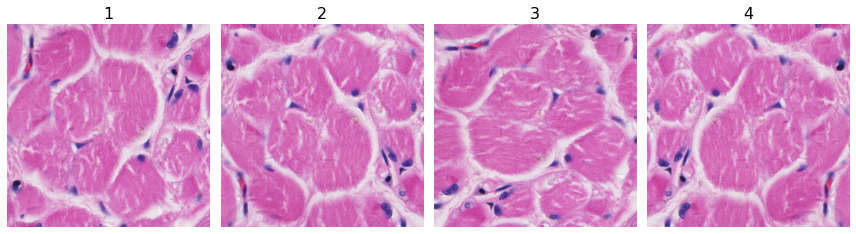

In [37]:
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(X[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [38]:
gradcam = Gradcam(model,
                  model_modifier=replace2linear,
                  clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score,
              X,
              penultimate_layer=-1)

# aa[0] = np.uint8(cm.jet(cam[0])[..., :3] * 255)
# aa[1] = np.flip((np.uint8(cm.jet(cam[1])[..., :3] * 255)),0)   
# aa[2] = np.rollaxis(np.uint8(cm.jet(cam[2])[..., :3] * 255),0,2)
# aa[3] = np.rot90((np.uint8(cm.jet(cam[3])[..., :3] * 255)),2)

In [56]:
def detection_3d(model1,timg1,m,temp_channel =1 ):

#     timg = Image.fromarray((test_img))
#     timg1 = np.array(timg)
    
    testarray = [[] for i in range(4)]
    testarray[0] = timg1 #原图
    testarray[1] = (np.flip(timg1,0))
    testarray[2] = np.rollaxis(timg1,0,2)
    testarray[3] = (np.rot90(timg1,2))
    
    
    testarray = np.asarray(testarray)
#     print(testarray.shape)
    
#     aa = modeleva_3d(model1,testarray)
#     aa[aa>th] = 125
#     aa[aa!=125] = 0

#     aa = np.asarray(np.transpose(aa,(0,2,3,1)).reshape(aa.shape[0],aa.shape[2],aa.shape[3],3))
    aa = np.zeros((4), dtype = np.object)
    
    aa[0] = modeleva_3d(model1,testarray[0],temp_channel) + m
    aa[1] = np.flip((modeleva_3d(model1,testarray[1],temp_channel)),0)   + m
    aa[2] = np.rollaxis(modeleva_3d(model1,testarray[2],temp_channel),0,2) + m
    aa[3] = np.rot90((modeleva_3d(model1,testarray[3],temp_channel)),2) + m
    
    aa = aa[0] + aa[1] + aa[2] + aa[3]
    aa = aa/4
    
    return aa

In [11]:
gradcam_3d(model, img1)

NameError: name 'preprocess_input' is not defined

In [55]:
def detection_3d(model1,timg1,m):

#     timg = Image.fromarray((test_img))
#     timg1 = np.array(timg)
    
    testarray = [[] for i in range(2)]
    testarray[0] = timg1 #原图
    testarray[1] = (np.flip(timg1,0))
#     testarray[2] = np.rollaxis(timg1,0,2)
#     testarray[3] = (np.rot90(timg1,2))
    
    testarray = np.asarray(testarray)
#     print(testarray.shape)
    
#     aa = modeleva_3d(model1,testarray)
#     aa[aa>th] = 125
#     aa[aa!=125] = 0

#     aa = np.asarray(np.transpose(aa,(0,2,3,1)).reshape(aa.shape[0],aa.shape[2],aa.shape[3],3))
    aa = np.zeros((2), dtype = np.object)
    
    aa[0] = modeleva_3d(model1,testarray[0],opchannel-1) + m
    aa[1] = np.flip((modeleva_3d(model1,testarray[1],opchannel-1)),0)   + m
#     aa[2] = np.rollaxis(modeleva_3d(model1,testarray[3]),0,2)
#     aa[3] = np.rot90((modeleva_3d(model1,testarray[4])),2)
    
    return aa